In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import decode_image, decode_jpeg
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
import random
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
image_size = (152, 240)

In [3]:
class StreamLoader:
    def __init__(self, dataset: torch.utils.data, batch_size: int, min_cache_size: int, max_cache_size: int, cache_update_probability: float):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.min_cache_size = min_cache_size
        self.max_cache_size = max_cache_size
        self.cache_update_probability = cache_update_probability
        self.preprocessor_batch_size = 1024

        self.cache = []

        self.make_processing_queue()

    def make_processing_queue(self):
        self.processing_queue = list(range(0, len(self.dataset)))
        random.shuffle(self.processing_queue)

    def fill_cache_one_batch(self):
        print("processing new batch")
        preprocessor_batch = []
        while len(preprocessor_batch) < self.preprocessor_batch_size:
            if len(self.processing_queue) == 0:
                self.make_processing_queue()

            idx = self.processing_queue.pop()
            preprocessor_batch.append(self.dataset[idx])

        processed_batch = self.preprocess_batch(preprocessor_batch)
        self.cache.extend(processed_batch)

    def fill_cache(self):
        while len(self.cache) <= self.min_cache_size:
            self.fill_cache_one_batch()

    def __iter__(self):
        return self

    def __next__(self):
        if len(self.cache) <= self.min_cache_size:
            self.fill_cache()

        num_tensors = len(self.cache)
        chosen_indices = random.sample(range(num_tensors), self.batch_size)
        
        batch = []
        updated_cache = []
        
        for i, obj in enumerate(self.cache):
            if i in chosen_indices:
                batch.append(obj)
                if random.random() >= self.cache_update_probability:
                    updated_cache.append(obj)
            else:
                updated_cache.append(obj)
        
        self.cache = updated_cache

        batch = self.stack_batch(batch)

        return batch
    
    def preprocess_batch(self, batch):
        frames_A = []
        frames_B = []
        flows = []
        for frame_A, frame_B, flow in batch:
            frames_A.append(frame_A)
            frames_B.append(frame_B)
            flows.append(flow)
            
        frames_A = decode_jpeg(frames_A, device = device)
        frames_B = decode_jpeg(frames_B, device = device)
        flows = decode_jpeg(flows, device = device)
        
        frames_A = [frame_A.type(torch.float32) / 256.0 for frame_A in frames_A]
        frames_B = [frame_B.type(torch.float32) / 256.0 for frame_B in frames_B]
        flows = [flow[:-1, ...].type(torch.float32) / 256.0 for flow in flows]

        batch = [(frame_A, frame_B, flow) for frame_A, frame_B, flow in zip(frames_A, frames_B, flows)]
    
        return batch
        
    
    def stack_batch(self, batch):
        frames_A = []
        frames_B = []
        flows = []
        for frame_A, frame_B, flow in batch:
            frames_A.append(frame_A)
            frames_B.append(frame_B)
            flows.append(flow)
            
        return torch.stack(frames_A, axis = 0), torch.stack(frames_B, axis = 0), torch.stack(flows, axis = 0)

In [4]:
class FlowImageDataset(Dataset):
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir

        self.frames_A_dir = os.path.join(dataset_dir, 'frames_A')
        self.frames_B_dir = os.path.join(dataset_dir, 'frames_B')
        self.flow_dir = os.path.join(dataset_dir, 'flows')
        
        self.image_names = sorted(os.listdir(self.frames_A_dir))
                
    def __len__(self):
        return len(self.image_names)
    
    def load_bytes(self, path):
        with open(path, "rb") as f:
            image_bytes = f.read()
            
        return torch.tensor(list(image_bytes), dtype=torch.uint8)

    def __getitem__(self, idx):
        frame_A = self.load_bytes(os.path.join(self.frames_A_dir, self.image_names[idx]))
        frame_B = self.load_bytes(os.path.join(self.frames_B_dir, self.image_names[idx]))
        flow = self.load_bytes(os.path.join(self.flow_dir, self.image_names[idx]))
        
        return frame_A, frame_B, flow

In [5]:
dataset = FlowImageDataset("moments_medium_std2")
loader = StreamLoader(dataset = dataset, batch_size = 32, min_cache_size = 5000, max_cache_size = 10000,
                      cache_update_probability = 0.05)

A, B, flow = next(iter(loader))
print(A.shape, flow.shape)

processing new batch
processing new batch
processing new batch
processing new batch
processing new batch
torch.Size([32, 3, 152, 240]) torch.Size([32, 2, 152, 240])


In [6]:
A, B, flow = next(iter(loader))
print(A.shape, flow.shape)

torch.Size([32, 3, 152, 240]) torch.Size([32, 2, 152, 240])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, output_channels, kernel_size=3, padding=1)

        self.batch_norm1 = nn.BatchNorm2d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm2d(output_channels)
        
        self.residual_conv = (
            nn.Conv2d(input_channels, output_channels, kernel_size=1)
            if input_channels != output_channels else nn.Identity()
        )
        
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.residual_conv(x)
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        
        x = x + residual
        x = self.activation(x)
        
        return x
    
class ResidualEncoder(nn.Module):
    def __init__(self):
        super(ResidualEncoder, self).__init__()
        
        self.block1 = ResidualBlock(3, 32, 32)
        self.block2 = ResidualBlock(32, 64, 64)
        self.block3 = ResidualBlock(64, 96, 96)
        
        self.pooling = nn.AvgPool2d(2)
        
    def forward(self, x):
        block1_output = self.block1(x)
        x = self.pooling(block1_output)
        block2_output = self.block2(x)
        x = self.pooling(block2_output)
        block3_output = self.block3(x)
        
        return block1_output, block2_output, block3_output
    
class FlowEncoder(nn.Module):
    def __init__(self):
        super(FlowEncoder, self).__init__()
        
        self.block1 = ResidualBlock(32 + 32, 64, 32)
        self.block2 = ResidualBlock(32 + 64 + 64, 64, 64)
        self.block3 = ResidualBlock(64 + 96 + 96, 96, 96)
        
        self.pooling = nn.AvgPool2d(2)
        
    def forward(self, encoder_A_output, encoder_B_output):
        A1, A2, A3 = encoder_A_output
        B1, B2, B3 = encoder_B_output
        
        x = torch.cat([A1, B1], axis = 1)
        block1_output = self.block1(x)
        x = self.pooling(block1_output)
        
        x = torch.cat([A2, B2, x], axis = 1)
        block2_output = self.block2(x)
        x = self.pooling(block2_output)
        
        x = torch.cat([A3, B3, x], axis = 1)
        block3_output = self.block3(x)
        
        return block1_output, block2_output, block3_output
    
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
        
class FlowDecoder(nn.Module):  
    def __init__(self):
        super(FlowDecoder, self).__init__()
        
        self.upconv1 = UpConv(in_channels = 96 + 96, out_channels = 64)
        self.upconv2 = UpConv(in_channels = 64 + 64 + 64, out_channels = 32)

        self.out_conv1 = nn.Conv2d(in_channels = 32 + 32 + 32, out_channels = 32, kernel_size=3, padding = 1)
        self.out_conv2 = nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size=1)
        
        self.batch_norm = nn.BatchNorm2d(32)
        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, encoder_A_output, flow_encoder_output):
        A1, A2, A3 = encoder_A_output
        f1, f2, f3 = flow_encoder_output
        
        x = torch.cat([A3, f3], axis = 1)
        x = self.upconv1(x)
        
        x = torch.cat([x, A2, f2], axis = 1)
        x = self.upconv2(x)
        
        x = torch.cat([x, A1, f1], axis = 1)
        
        x = self.out_conv1(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.out_conv2(x)
        
        x = (torch.tanh(x) + 1.0) / 2.0
        
        return x

class OpticalFlowNetwork(nn.Module):
    def __init__(self):
        super(OpticalFlowNetwork, self).__init__()
        self.residual_encoder = ResidualEncoder()
        self.flow_encoder = FlowEncoder()
        self.flow_decoder = FlowDecoder()

    def forward(self, frameA, frameB):
        encoder_A_output = self.residual_encoder(frameA)
        encoder_B_output = self.residual_encoder(frameB)
        
        flow_encoder_output = self.flow_encoder(encoder_A_output, encoder_B_output)
        x = self.flow_decoder(encoder_A_output, flow_encoder_output)
        
        return x

In [13]:
from IPython.display import clear_output

class VisualDataLogger:
    def __init__(self):
        self.train_hist = np.array(np.empty([0]))
        self.test_hist = np.array(np.empty([0]))
        
    def reset(self):
        self.train_hist = np.array(np.empty([0]))
        self.test_hist = np.array(np.empty([0]))
        
    def add_train_value(self, value):
        self.train_hist = np.append(self.train_hist, value)
        
    def add_test_value(self, value):
        self.test_hist = np.append(self.test_hist, value)
        
    def clear_and_plot(self):
        clear_output(wait=True)
        plt.plot(np.arange(0, len(self.train_hist)), self.train_hist, label='Train')
        plt.plot(np.arange(0, len(self.test_hist)), self.test_hist, label='Test')
        plt.legend()
        plt.show()

In [33]:
class Trainer:
    def __init__(self, model, device, logger, train_loader, test_loader, num_epochs, start_lr=3e-4, end_lr=1e-4, weight_decay=0):
        self.model = model
        self.device = device
        self.logger = logger
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        
        self.optimizer = optim.Adam(model.parameters(), lr=start_lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=end_lr)
        
    def generate_new_filename(self):
        start = "opticla_flow_network_autosave_"
        i = 0
        while os.path.isfile(f"{start}{i}.pth"):
            i += 1
        return f"{start}{i}.pth"

    
    def edge_aware_smoothness_loss(self, flow, image, alpha=10.0):
        # Compute image gradients
        grad_x = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]), axis = 1)
        grad_y = torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]), axis = 1)
        
        # Compute flow gradients
        flow_grad_x = torch.mean(torch.abs(flow[:, :, :, :-1] - flow[:, :, :, 1:]), axis = 1)
        flow_grad_y = torch.mean(torch.abs(flow[:, :, :-1, :] - flow[:, :, 1:, :]), axis = 1)
        
        # Weight by image gradients (edge-aware)
        loss_x = (torch.exp(-alpha * grad_x) * flow_grad_x).mean()
        loss_y = (torch.exp(-alpha * grad_y) * flow_grad_y).mean()
        
        return loss_x + loss_y
    
    def calculate_loss(self, outputs, target, frames_A):
        mse_loss = torch.mean((outputs - target)**2)
        smoothness_loss = self.edge_aware_smoothness_loss(outputs, frames_A)
        return mse_loss + smoothness_loss
        
    def transfer(self, data, device):
        return [item.to(device) for item in data]

    def process_epoch(self, data_loader, mode="train"):
        total_loss = 0.0
        count = 0
        self.model.train() if mode == "train" else self.model.eval()
        for batch in data_loader:
            count += 1
            if count == 256:
                break
            
            frames_A, frames_B, target_flow = batch

            with torch.set_grad_enabled(mode == "train"):
                outputs = self.model(frames_A, frames_B)
                loss = self.calculate_loss(outputs, target_flow, frames_A)

                if mode == "train":
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
               
            # show
            with torch.no_grad():
                if mode == "show":
                    plt.figure(figsize=(10, 6))
                    batch_size = frames_A.shape[0]
                    void_channel = torch.ones([batch_size, 1, image_size[0], image_size[1]]).to(device) * 0.5
                    target_flow = torch.cat([target_flow, void_channel], 1)
                    outputs = torch.cat([outputs, void_channel], 1)
                    
                    num_examples = min(6, batch_size)
                    for i in range(num_examples):
                        ax = plt.subplot(4, num_examples, num_examples * 0 + i + 1)
                        plt.imshow(frames_A[i].permute(1, 2, 0).cpu().numpy())
                        plt.axis("off")

                        ax = plt.subplot(4, num_examples, num_examples * 1 + i + 1)
                        plt.imshow(frames_B[i].permute(1, 2, 0).cpu().numpy())
                        plt.axis("off")

                        ax = plt.subplot(4, num_examples, num_examples * 2 + i + 1)
                        plt.imshow(target_flow[i].permute(1, 2, 0).cpu().numpy())
                        plt.axis("off")

                        ax = plt.subplot(4, num_examples, num_examples * 3 + i + 1)
                        plt.imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
                        plt.axis("off")

                    plt.show()
                    
                    # use only the first batch to show
                    break

            total_loss += loss.item()
        
        mean_loss = total_loss / count
        return mean_loss

    def train(self):
        try:
            for epoch in range(self.num_epochs):
                print(f"Running epoch {epoch+1}/{self.num_epochs}")
                
                # Training phase
                train_loss = self.process_epoch(self.train_loader, mode="train")
                self.logger.add_train_value(train_loss)
                print(f"Train Loss: {train_loss}")
                
                # Testing phase
                if self.test_loader:
                    test_loss = self.process_epoch(self.test_loader, mode="test")
                    self.logger.add_test_value(test_loss)
                    print(f"Test Loss: {test_loss}")
                
                # Learning rate and scheduler
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Current LR: {current_lr}")
                self.scheduler.step()

                # Plot and clear the logger for the next iteration
                self.logger.clear_and_plot()
                
                # Show phase
                self.process_epoch(self.train_loader, mode="show")

        except KeyboardInterrupt:
            print("Training interrupted by user.")

        # Save model
        #filename = self.generate_new_filename()
        #torch.save(self.model.state_dict(), filename)
        #print(f"Model saved as {filename}")


In [34]:
logger = VisualDataLogger()
model = OpticalFlowNetwork().to(device)
model.load_state_dict(torch.load("medium_0.1.pth", weights_only = True))
num_epochs = 100
trainer = Trainer(model, device, logger, loader, None, num_epochs)

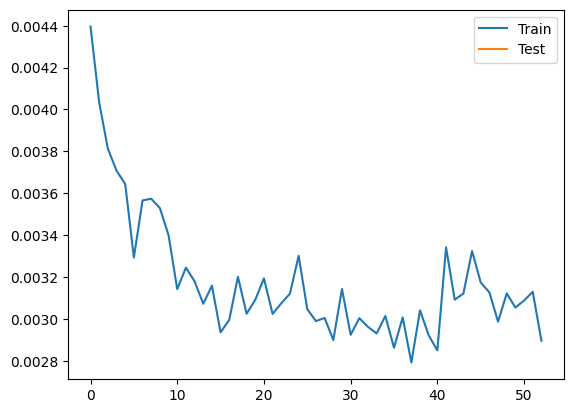

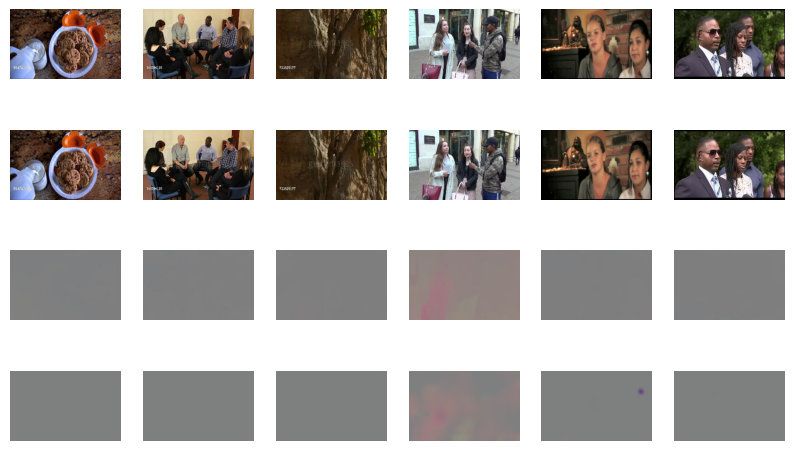

Running epoch 54/100
processing new batch
Training interrupted by user.


In [35]:
trainer.train()

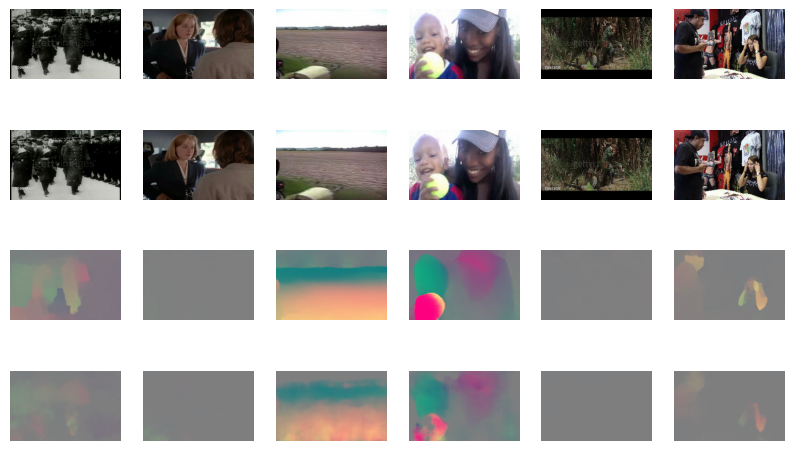

0.0

In [31]:
trainer.process_epoch(trainer.train_loader, mode="show")

In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [36]:
torch.save(model.state_dict(), "medium_0.11.pth")